In [0]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import kde
from google.colab import files
import pandas as pd

# Figure size fonts for latex:
title_size = 44
axis_size = 42
legend_size = 40

# Regular font size:
title_size = 24
axis_size = 22
legend_size = 20

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Univariate HDP

#### UvNormal Modelling

In [0]:
# Functions to model a univariate DP draw and build a sample distribution out of G.
def dp_draw_univariate(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta = base_function.rvs(1)[0]
        dp_sample.append([pi_i, sample_theta])
        remain_prob *= (1-sample_pi)
        
    return np.array(dp_sample, dtype=np.float64)

In [0]:
# Functions to model a univariate HDP draw and build a sample distribution out of G.
# Note! base_function is a matrix of size (k_trunc, 2)
def hdp_draw_univariate(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    hdp_sample = list()
    while k_trunc != len(hdp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        
        sample_theta = np.random.choice(base_function[:, 1], 1,
              p=base_function[:, 0])
        
        hdp_sample.append([pi_i, sample_theta])
        remain_prob *= (1-sample_pi)
    return np.array(hdp_sample, dtype=np.float64)

# Multivaraite Normal Mixture HDP

#### MvNormal HDP Functions

In [0]:
# Functions to model a multivariate DP draw and build a sample distribution out of G.
def dp_draw(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta = [item for item in base_function.rvs(1)]
        dp_sample.append([pi_i] + sample_theta)
        remain_prob *= (1-sample_pi)
    return np.array(dp_sample, dtype=np.float64)

In [0]:
# Functions to model a multivariate HDP draw and build a sample distribution out of G.
# Note! base_function is now a matrix of size (k_trunc, 2)
def hdp_draw(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    hdp_sample = list()
    while k_trunc != len(hdp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta_ind = np.random.choice([i for i in range(len(base_function))], 1, p=base_function[:, 0])
        sample_theta = base_function[sample_theta_ind, 1:]
        hdp_list = np.zeros(1+len(sample_theta[0]))
        hdp_list[0] = pi_i
        for i in range(len(sample_theta[0])):
            hdp_list[i+1] = sample_theta[0][i]
        hdp_sample.append(hdp_list)
        remain_prob *= (1-sample_pi)
        
    return np.array(hdp_sample, dtype=np.float64)

In [0]:
def dirichlet_process(alpha, base_function, k_trunc, num_samples, dim):
    dp_samples = np.zeros((num_samples, k_trunc, dim +1 ))
    for i in range(0, num_samples):
        sample = dp_draw(alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        dp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % dp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % dp_samples.shape[1])
    print('\t Bease measure: %s' % base_function)
    return dp_samples

In [0]:
def hierarchical_dirichlet_process(alpha, base_function, k_trunc, num_samples, dim):
    hdp_samples = np.zeros((num_samples, k_trunc, dim+1))
    for i in range(0, num_samples):
        sample = hdp_draw(alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        hdp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % hdp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % hdp_samples.shape[1])
    # print('\t Bease measure: %s' % base_function)
    return hdp_samples

#### MvNormal HDP Modelling 

#### Example 1

In [0]:
# # multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
# mu = [0.5, -0.2, 0.9]
# cov = [[2.0, 0.3, 0.1], [0.2, 0.5, 0.6], [0.3, 0.5, 0.88]]
# multinorm_base = stats.multivariate_normal(mu, cov)

# multinorm_base.rvs(1)

# num_samples = 1
# # base_function = stats.norm(loc=0., scale=3)
# base_function = multinorm_base


# # Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# # tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

# k_trunc = 20

# alpha = 100
# dim = len(mu)
# dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=dim)

# print("Shape", dp_medium_alpha.shape)
# print()
# print(str(dp_medium_alpha.shape[0]) + " processe(s); " + str(dp_medium_alpha.shape[1]) + " parameters; parameter dims of " + str(dp_medium_alpha.shape[2] - 1) + " where these dims are the last d indices and the first is their probability.")

In [0]:
# hdp_dict = dict()

# G_0 = dp_medium_alpha[0, :, :]
# G_0[:,0] /= np.sum(G_0[:,0])

# k_trunc = 5

# alpha = 100
# hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=dim)

# print()
# print(hdp_medium_alpha.shape)
# print()
# print(str(hdp_medium_alpha.shape[0]) + " processe(s); " + str(hdp_medium_alpha.shape[1]) + " parameters; parameter dims of " + str(hdp_medium_alpha.shape[2] - 1) + " where these dims are the last d indices and the first is their probability.")

#### Example 2

##### DP results

In [0]:
num_samples = 1
# base_function = stats.norm(loc=0., scale=3)
multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
base_function = multinorm_base

dp_dict = dict()

# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

k_trunc = 100

alpha = 1000
dp_large_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_large_alpha

alpha = 100
dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_medium_alpha

alpha = 10
dp_small_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_small_alpha

DP Constructed:
	 Number of samples: 1
	 Alpha: 10
	 Truncation value: 100
	 Bease measure: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x7fb9d8ac7d68>


##### DP plots

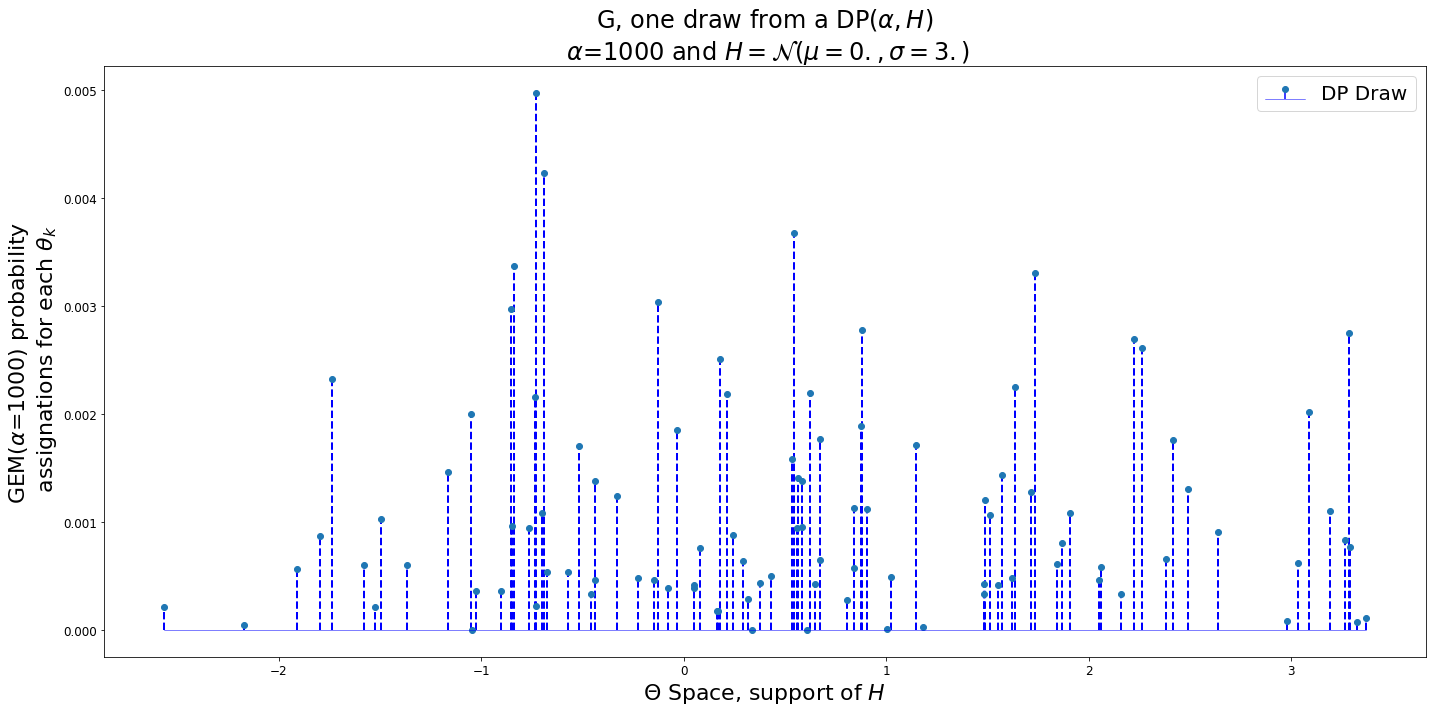

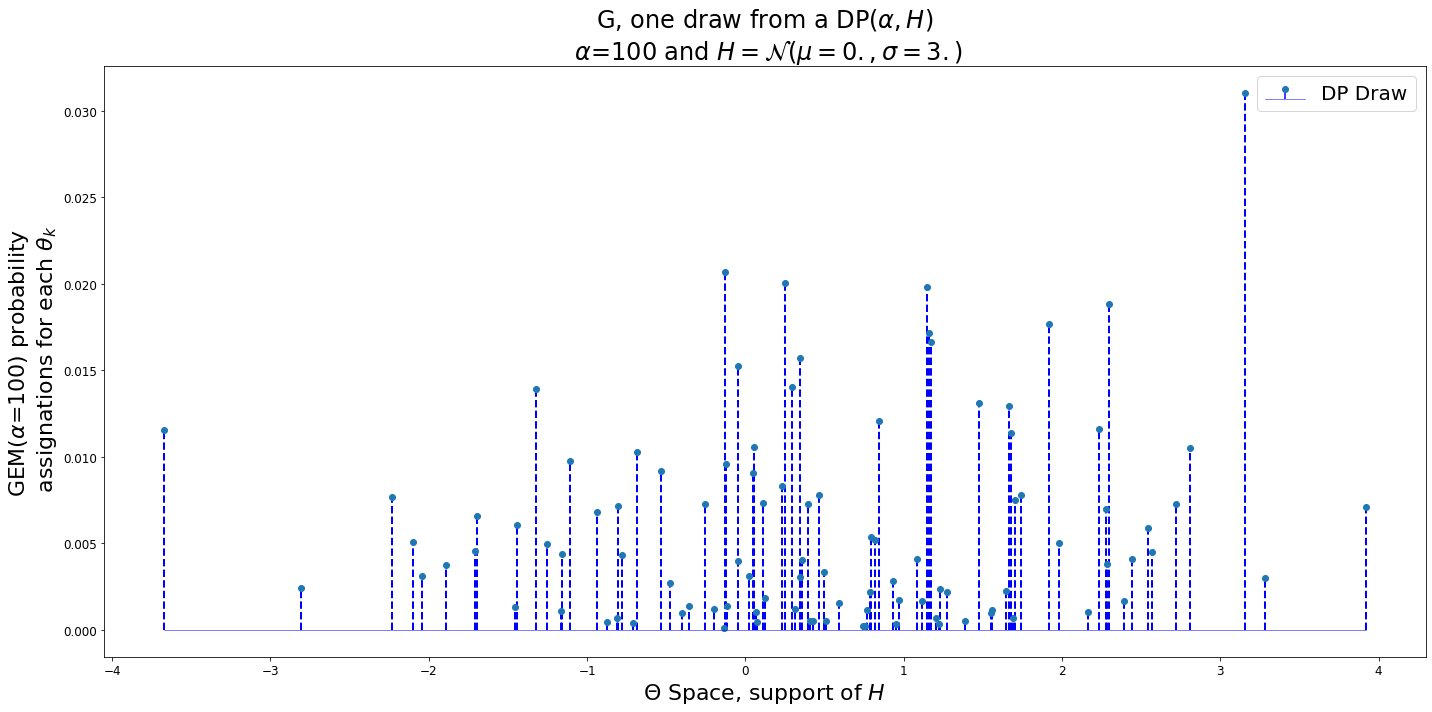

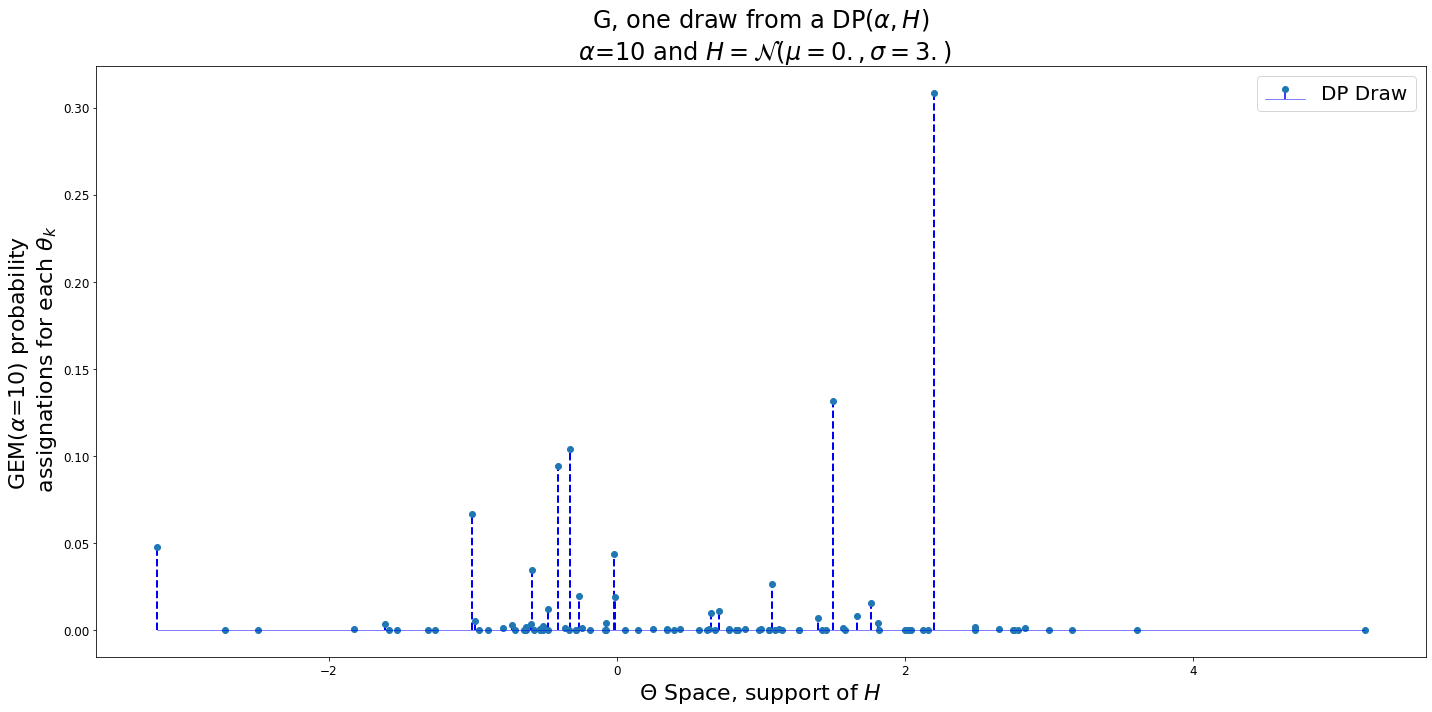

In [0]:
for alpha in dp_dict:
    dp_samples = dp_dict[alpha]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)

    ax.set_title(r'G, one draw from a DP($\alpha, H$)'+'\n'+r' $\alpha$=%s and $H=\mathcal{N}(\mu=0.,\sigma=3.)$' % alpha, size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    # plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

In [0]:
markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)


##### HDP Results

In [0]:
hdp_dict = dict()
# print(dp_medium_alpha[0, :, :].shape)
G_0 = dp_medium_alpha[0, :, :]
# print(dp_samples)
G_0[:,0] /= np.sum(G_0[:,0])


alpha = 1000
hdp_large_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_large_alpha

alpha = 100
hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_medium_alpha

alpha = 10
hdp_small_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_small_alpha


DP Constructed:
	 Number of samples: 1
	 Alpha: 10
	 Truncation value: 100


##### HDP Plots

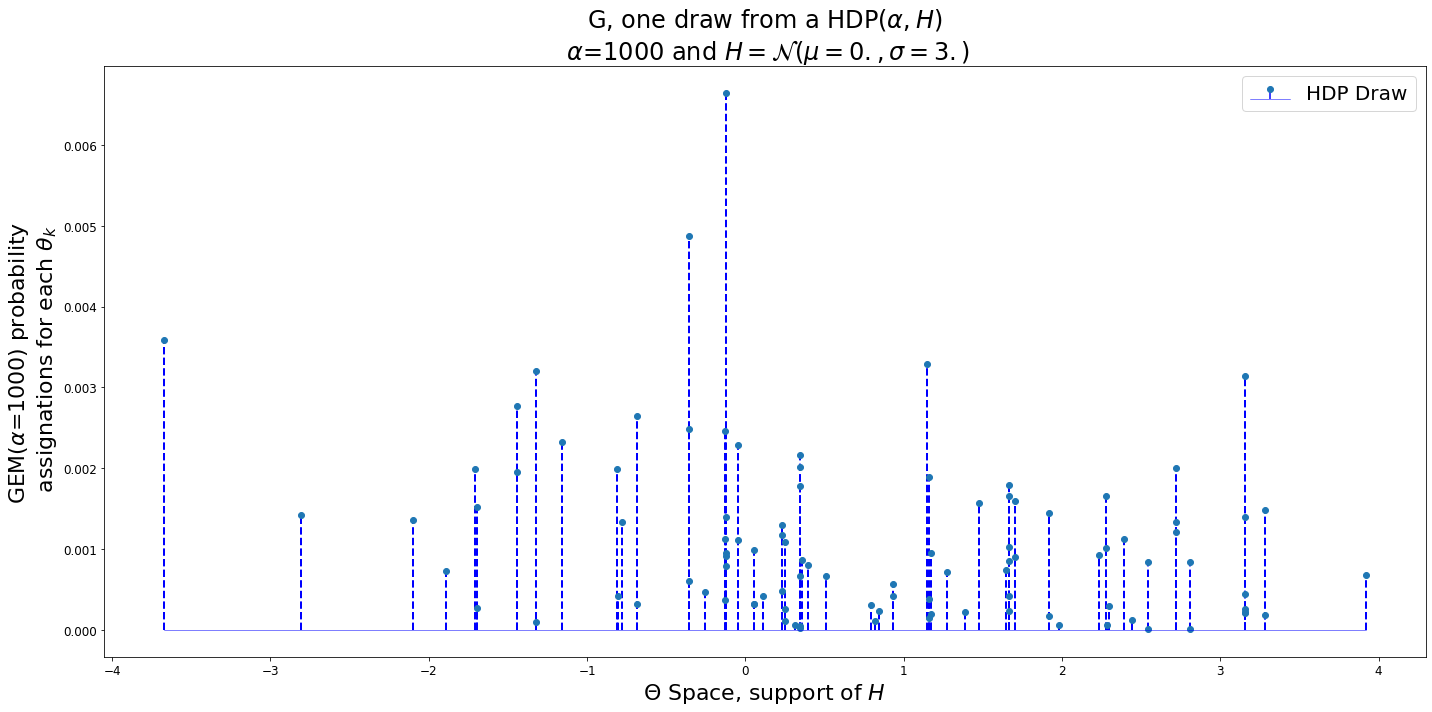

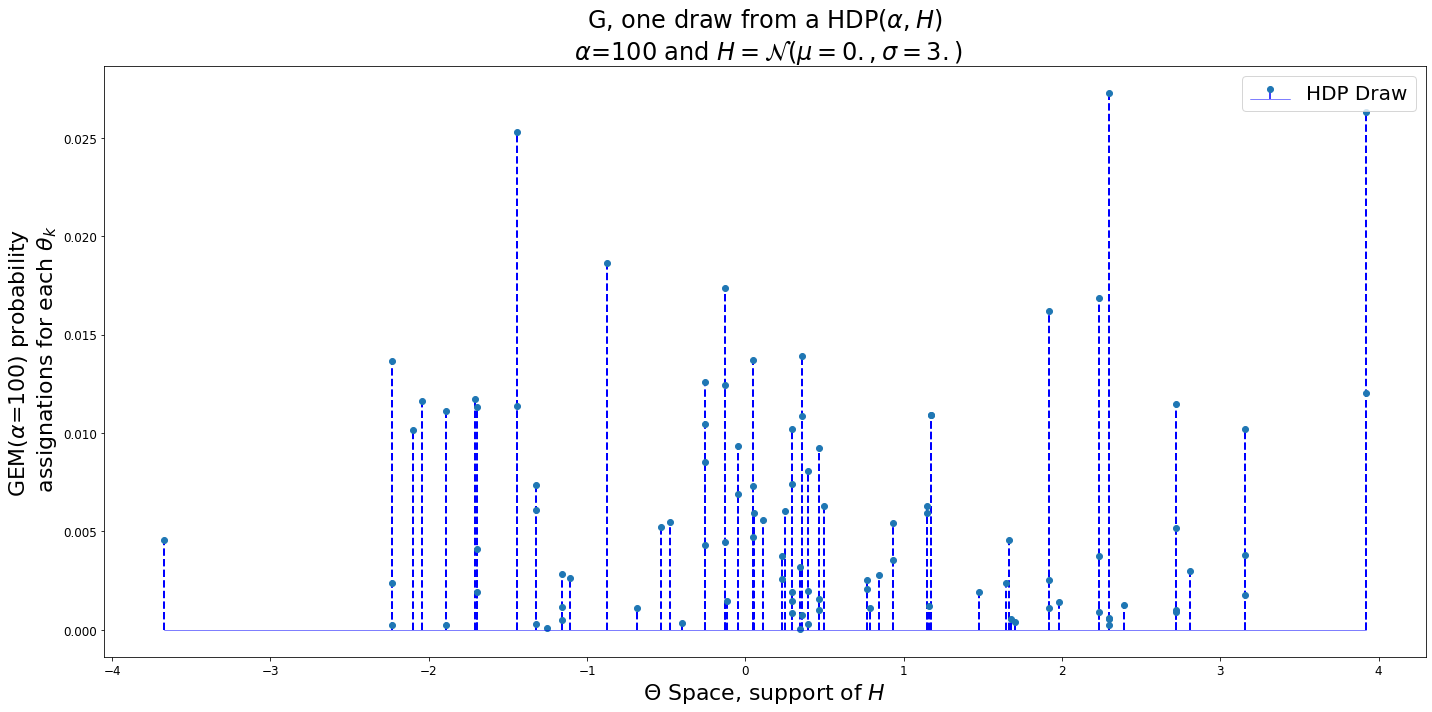

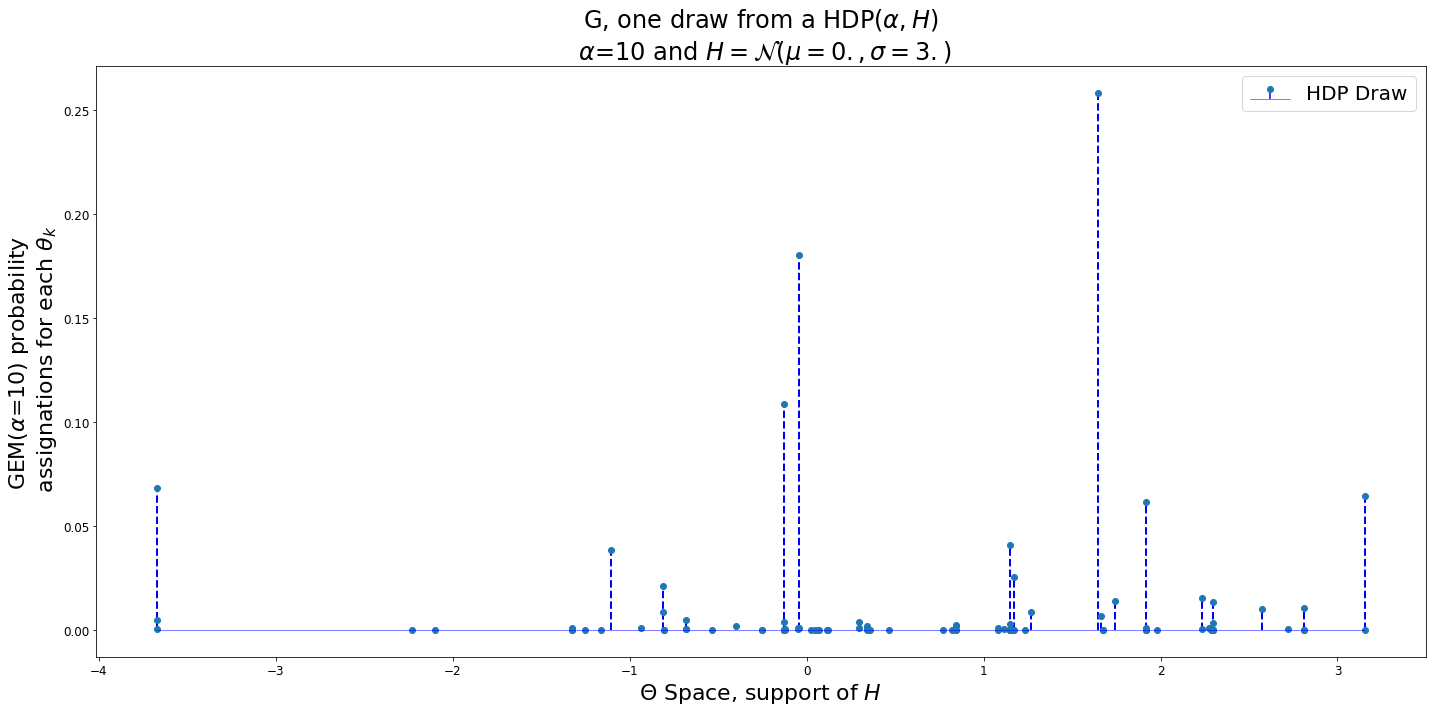

In [0]:
for alpha in hdp_dict:
    hdp_samples = hdp_dict[alpha]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(hdp_samples[0, :, 1], hdp_samples[0, :, 0], '--', label='HDP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)

    ax.set_title(r'G, one draw from a HDP($\alpha, H$)'+'\n'+r' $\alpha$=%s and $H=\mathcal{N}(\mu=0.,\sigma=3.)$' % alpha, size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    # plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

#### Generate Data

In [0]:
num_docs = 10
num_samples = 1
multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
base_function = multinorm_base

dp_dict = dict()

# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.
k_trunc = 100

alpha = 10
dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_medium_alpha

hdp_dict = dict()

G_0 = dp_medium_alpha[0, :, :]
G_0[:,0] /= np.sum(G_0[:,0])

data = []
for doc in range(num_docs):
  # Document level topic distribution
  hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)[0]

  # Get topics/params in doc
  param_idx = np.random.choice(np.array(len(hdp_medium_alpha)), 10, p=hdp_medium_alpha[:, 0]/sum(hdp_medium_alpha[:, 0]))
  params = hdp_medium_alpha[param_idx][:, 1:]

  # Get points
  for param in params:
    data += list(np.random.multivariate_normal(param, np.array([[.1,0,], [0,.1]]), size=25))


print(G_0[:, 1:].shape)
df_hdp_G0 = pd.DataFrame(G_0[:, :], columns = ['weight', 'x1', 'x2']) 
df_hdp_G0.to_csv('hdp_G_0.csv') 
files.download('hdp_G_0.csv')

df_hdp_data = pd.DataFrame(data, columns = ['x1', 'x2']) 
df_hdp_data.to_csv('hdp_data.csv') 
files.download('hdp_data.csv')


DP Constructed:
	 Number of samples: 1
	 Alpha: 10
	 Truncation value: 100
(100, 2)


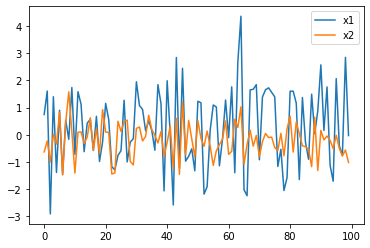

In [0]:
df_hdp_G0.plot()

### Chinese Restaurant Process

In [0]:
def compute_cum_prob(counts, alpha):
    probs = np.array(counts)
    norm = probs.sum() + alpha
    probs = probs/norm
    probs = list(probs)
    probs.append(alpha/norm)
    
    cum = np.zeros(len(probs))
    for i in range(len(probs)):
        cum[i] = np.sum(probs[:i+1])        
    return cum

def new_customer(counts, alpha):
    unif = stats.uniform()
    u = unif.rvs(1)
    cum = compute_cum_prob(counts, alpha)
    for i, prob_c in enumerate(cum):
        if u < prob_c:
            if i == len(cum)-1:
                counts.append(1)
            else:
                counts[i] +=1
            break
    return counts

def chinese_restaurant_process(counts, alpha, n_cust):
    for j in range(n_cust):
        counts = new_customer(counts, alpha)
    return counts

KeyboardInterrupt: ignored

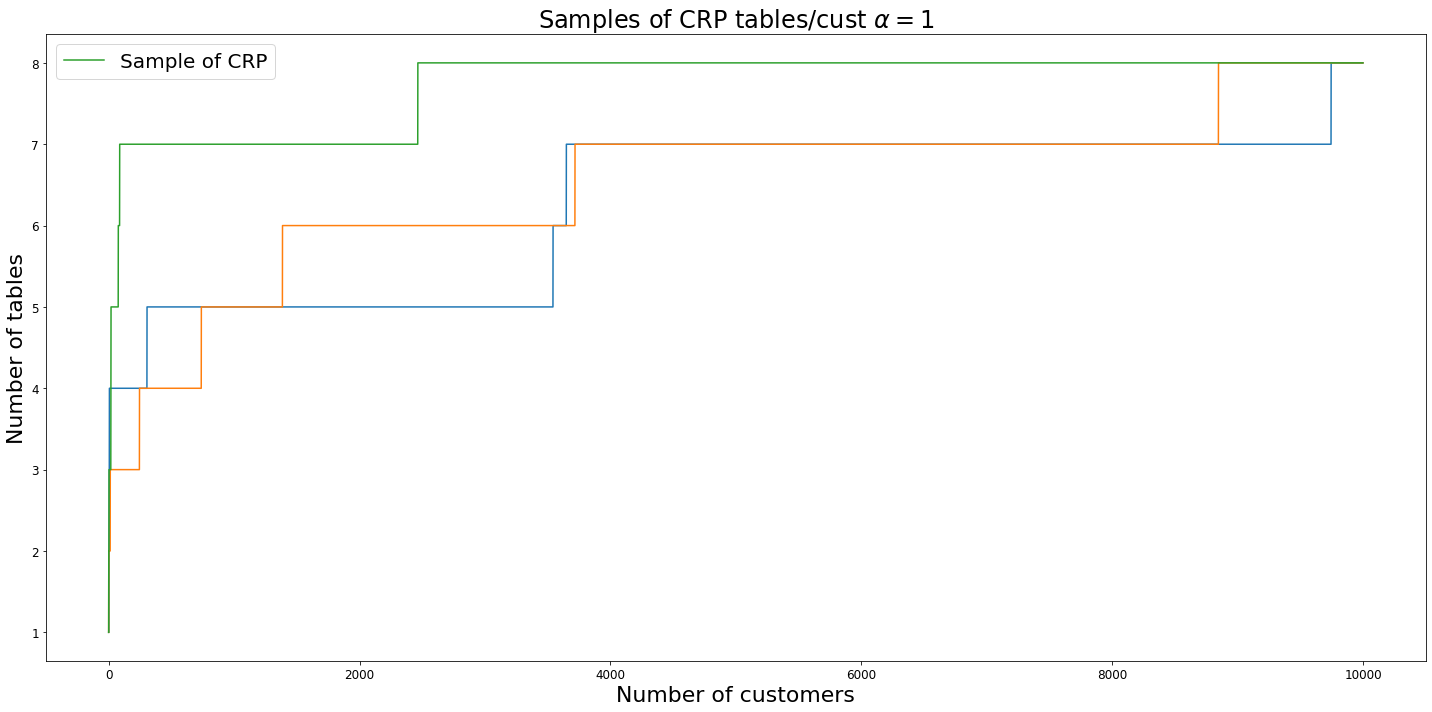

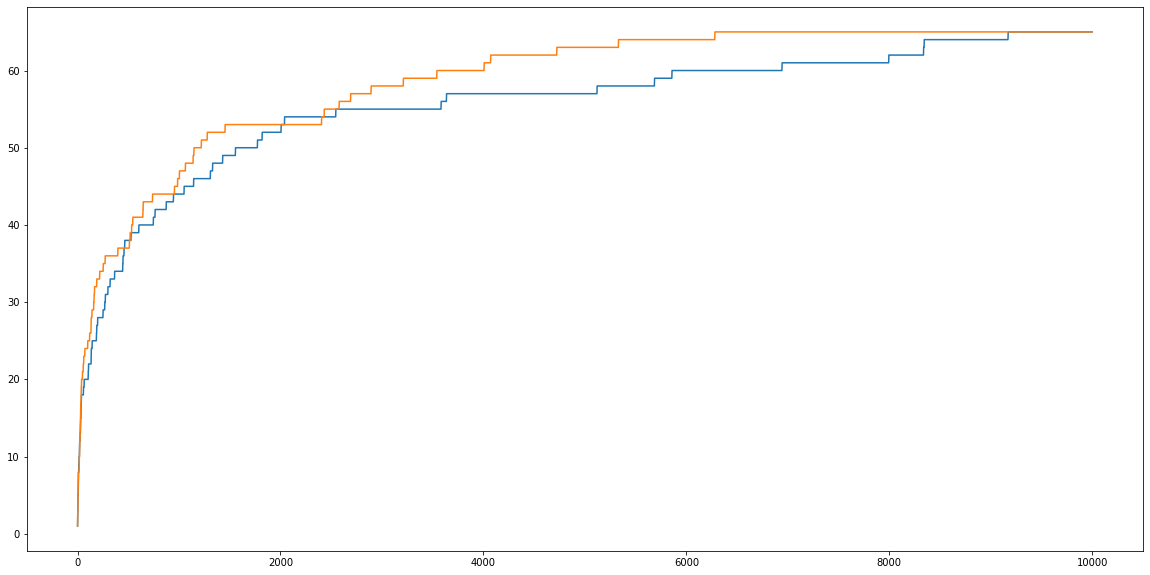

In [0]:
# Plot parameters
total_customers = 10000
samples_crp = 3

# for alpha in [1, 10, 100]:
#     fig = plt.figure(figsize=(20, 10))
#     ax = fig.add_subplot(111)
    
#     for j in range(samples_crp):
#         counts = list()
#         num_tables = list()
#         for i in range(total_customers):
#             counts = chinese_restaurant_process(counts, alpha, n_cust=1)
#             num_tables.append(len(counts))
#             print('Processed customer: Alpha %s Sample %s %s/%s' % (alpha, j, i+1, total_customers))
#             clear_output(wait=True)
#         if j != samples_crp-1:
#             ax.plot(range(total_customers), num_tables)
#     ax.plot(range(total_customers), num_tables, label='Sample of CRP')    
#     ax.set_title(r'Samples of CRP tables/cust $\alpha=%s$' % alpha, size=title_size)
#     ax.set_ylabel('Number of tables', size=axis_size)
#     ax.set_xlabel('Number of customers', size=axis_size)
#     ax.tick_params(labelsize=axis_size-10) 
#     plt.legend(prop={'size': legend_size})
#     plt.tight_layout()
#     plt.savefig('images/crp/chinese_restaurant_process_tables_alpha_%s.png' % alpha, dpi=100)

In [0]:
# counts

### Genism HDP Results

In [0]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp = HdpModel(common_corpus, common_dictionary)

unseen_document = [(1, 3.), (2, 4)]
doc_hdp = hdp[unseen_document]

topic_info = hdp.print_topics(num_topics=20, num_words=10)

hdp.update([[(1, 2)], [(1, 1), (4, 5)]])

print('doc_hdp: ', doc_hdp, '\n')
print('topic_info: ', topic_info)

# TDP


#### TDP Modelling

In [0]:
"""
Returns m'_kt as in https://event.cwi.nl/uai2010/papers/UAI2010_0296.pdf
"""
def get_m_prime(ts, m, delta=3, lam=10):
  m_prime_t = defaultdict(lambda: 0)
  delta_slice = max(0, ts - delta)
  m_delta = m[delta_slice:ts].copy()  # Should be a matrix consisting of row of m at the last delta - 1 rows
  for m_at_step in m_delta: # Getting m in given timestep
    for param in m_at_step.keys():
      m_prime_t[param] += np.exp(-delta/lam)
  return m_prime_t

def get_unique_atoms(ts, m, delta=3):
  unique_atoms = set()
  delta_slice = max(0, ts - delta)
  m_delta = m[delta_slice:ts].copy()  # Should be a matrix consisting of row of m at the last delta - 1 rows
  for m_at_step in m_delta: # Getting m in given timestep
    for mu in m_at_step.keys():
      unique_atoms.add(mu)
  return unique_atoms

def sum_over_mk(m_prime):
  total = 0 
  for param in m_prime.keys():
    total += m_prime[param]
  return total

# Functions to model a DP draw and build a sample distribution out of G.
def temporal_dp_draw(m, ts, atoms, temporal_alphas, temporal_base_dist_params, alpha, base_function, k_trunc):
    if ts == 0:
      m_prime_t = defaultdict(lambda: 0)
      temporal_base_dist_params.append((np.array([0.5, -0.2]), np.array([[2.0, 0.3], [0.3, 0.5]])))
    else:
      m_prime_t = get_m_prime(ts, m)
      unique_atoms = get_unique_atoms(ts, m)

      c = alpha/(sum_over_mk(m_prime_t) + alpha)
      d = 0
      for i in m_prime_t.keys():
        d += m_prime_t[i] / (sum_over_mk(m_prime_t) + alpha)

      mus_t = np.array([0.5, -0.2]) * c + d
      covs_t = c * c * np.array([[2.0, 0.3], [0.3, 0.5]])

      temporal_base_dist_params.append((mus_t, covs_t))
      base_function = stats.multivariate_normal(mus_t, covs_t)

    alpha_t = alpha + sum_over_mk(m_prime_t)
    temporal_alphas.append(alpha_t)

    beta_dist = stats.beta(a=1, b=alpha_t)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta = [item for item in base_function.rvs(1)]
        dp_sample.append([pi_i] + sample_theta)
        remain_prob *= (1-sample_pi)
        
    return np.array(dp_sample, dtype=np.float64)



In [0]:
def temporal_dirichlet_process(m, ts, atoms, temporal_alphas, temporal_base_dist_params, alpha, base_function, k_trunc, num_samples, dim):
    dp_samples = np.zeros((num_samples, k_trunc, dim +1 ))
    for i in range(0, num_samples):
        sample = temporal_dp_draw(m, ts, atoms, temporal_alphas, temporal_base_dist_params, alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        dp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % dp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % dp_samples.shape[1])
    print('\t Bease measure: %s' % base_function)
    return dp_samples

#### TDP Data Generation

In [0]:
multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

num_samples = 1
# base_function = stats.norm(loc=0., scale=3)
base_function = multinorm_base

dp_dict = dict()
hdp_dict = dict()

# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

k_trunc = 100
steps = 10
alpha = 100
m = []
atoms = np.zeros((steps, k_trunc, 2))
temporal_alphas = []
temporal_base_dist_params = []
gen_data = []
temporal_G0s = []

# dp_large_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
# dp_dict[alpha] = dp_large_alpha

for ts in range(steps):
  # Distribution of topics (top level of HDP)
  dp_medium_alpha = temporal_dirichlet_process(m, ts, atoms, temporal_alphas, temporal_base_dist_params, alpha, base_function, k_trunc, num_samples, dim=2)
  dp_dict[ts] = dp_medium_alpha
  atoms[ts] = dp_medium_alpha[0][:, 1:]
  G_0 = dp_medium_alpha[0]
  G_0[:,0] /= np.sum(G_0[:,0])
  temporal_G0s.append(G_0[:,1:])

  # IF I ONLY WANT 1 DOC PER EPOCH, BACK INSIDE THE FOR LOOP AND UNCOMMENT 'IF I == 0'
  data_for_ts = []

  # Assume 10 documents
  for i in range(10):
    # Gives a distribution over topics in each doc
    hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
    hdp_dict[ts] = hdp_medium_alpha

    # UPDATE M MATRIX
    # Make assumption of 10 non-unique topics in doc --> make 10 samples from our hdp_medium_alpha
    n = len(hdp_medium_alpha[0][:, 1:])
    z = sum(hdp_medium_alpha[0][:, 0].tolist())
    weights = np.array(hdp_medium_alpha[0][:, 0].tolist())
    samples = np.random.choice(np.arange(n), 10, p=weights/z)

    m_t = defaultdict(lambda: 0)

    # Generate data (think of this as the words) for a single "doc"
    # while updating M Matrix (don't want to plot too many things, so just plotting the evolution of topics for a single doc)
    
    for idx in samples:
      # Index of component k
      component = hdp_medium_alpha[0][:, 1:][idx]
      m_t[tuple(component)] += 1

      # if i == 0:
      data_for_ts += list(np.random.multivariate_normal(component, [[.01, 0], [0, .01]], 25))


    m.append(m_t)

  # IF I ONLY WANT 1 DOC PER EPOCH, MOVE NEXT 2 LINES IN ONE TAB
  if data_for_ts:
    gen_data.append(np.array(data_for_ts))

DP Constructed:
	 Number of samples: 1
	 Alpha: 100
	 Truncation value: 100


#### TDP Atoms

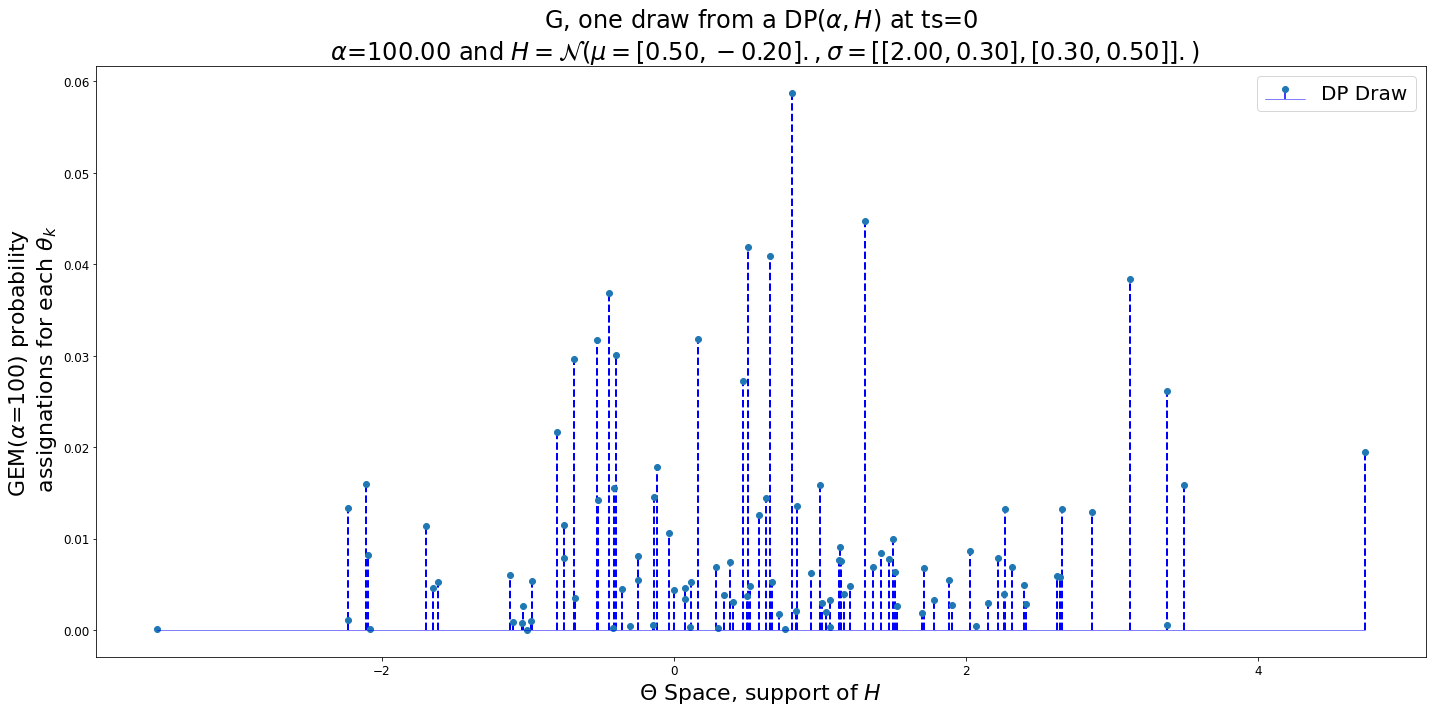

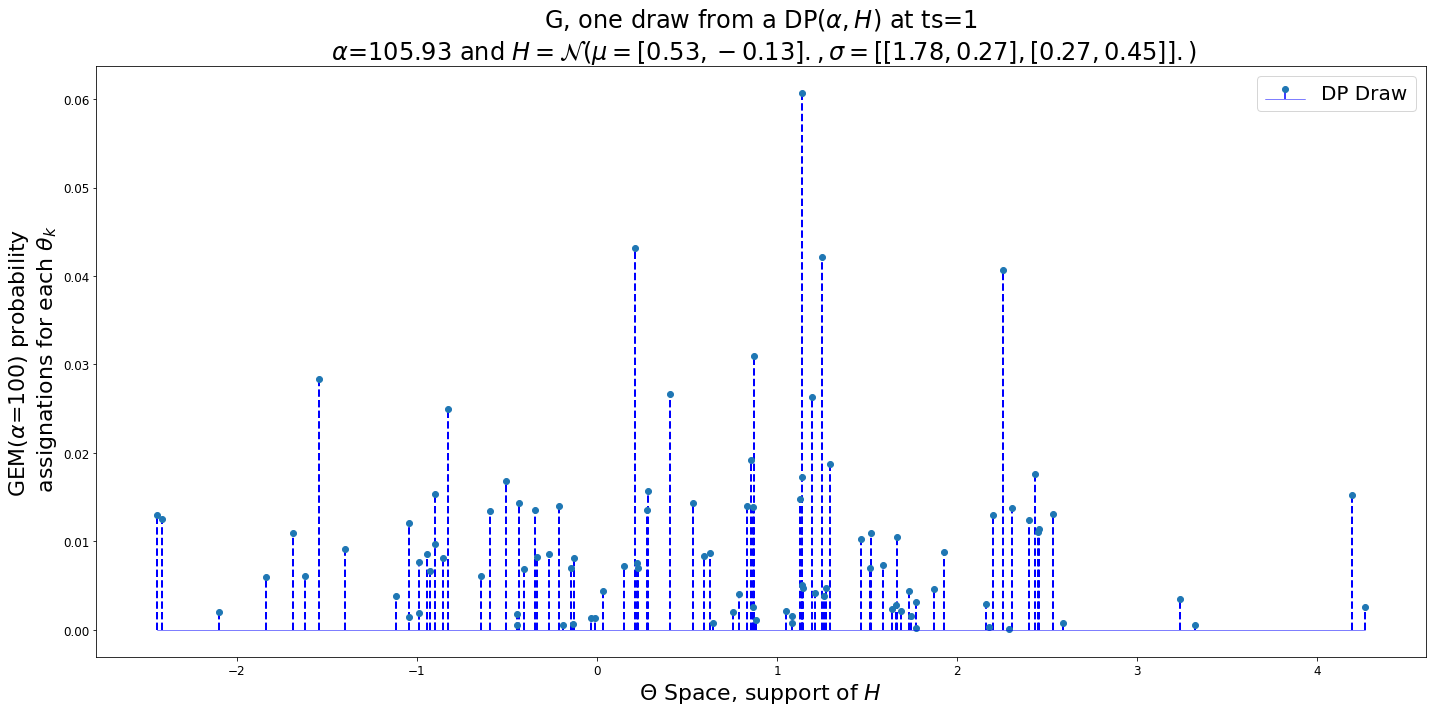

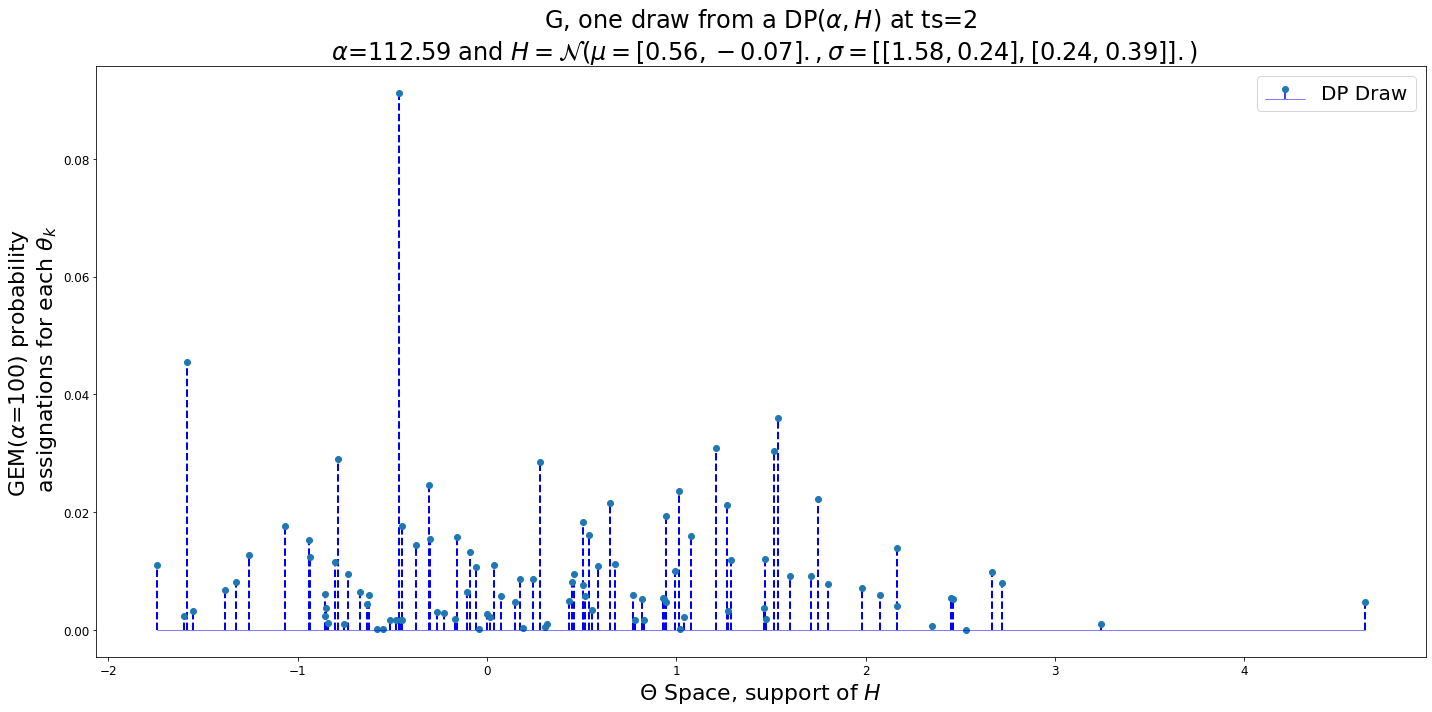

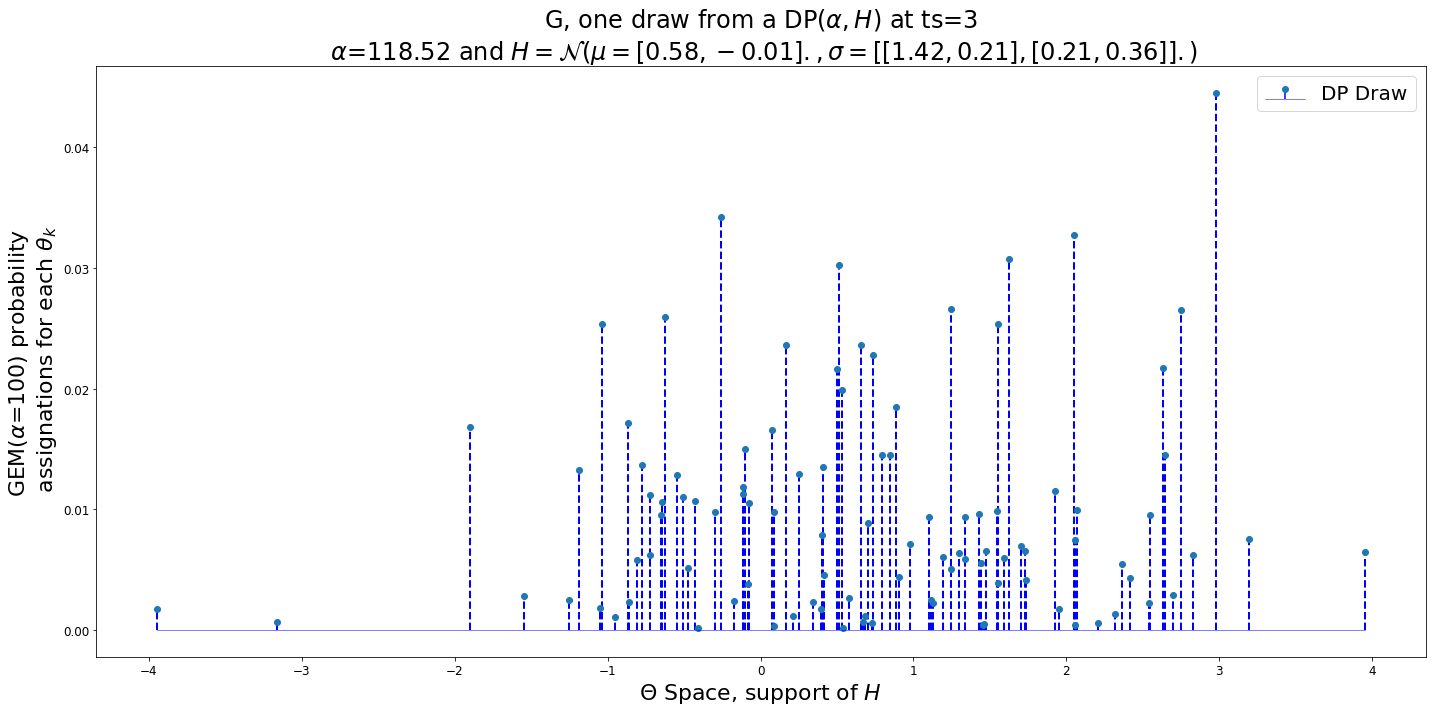

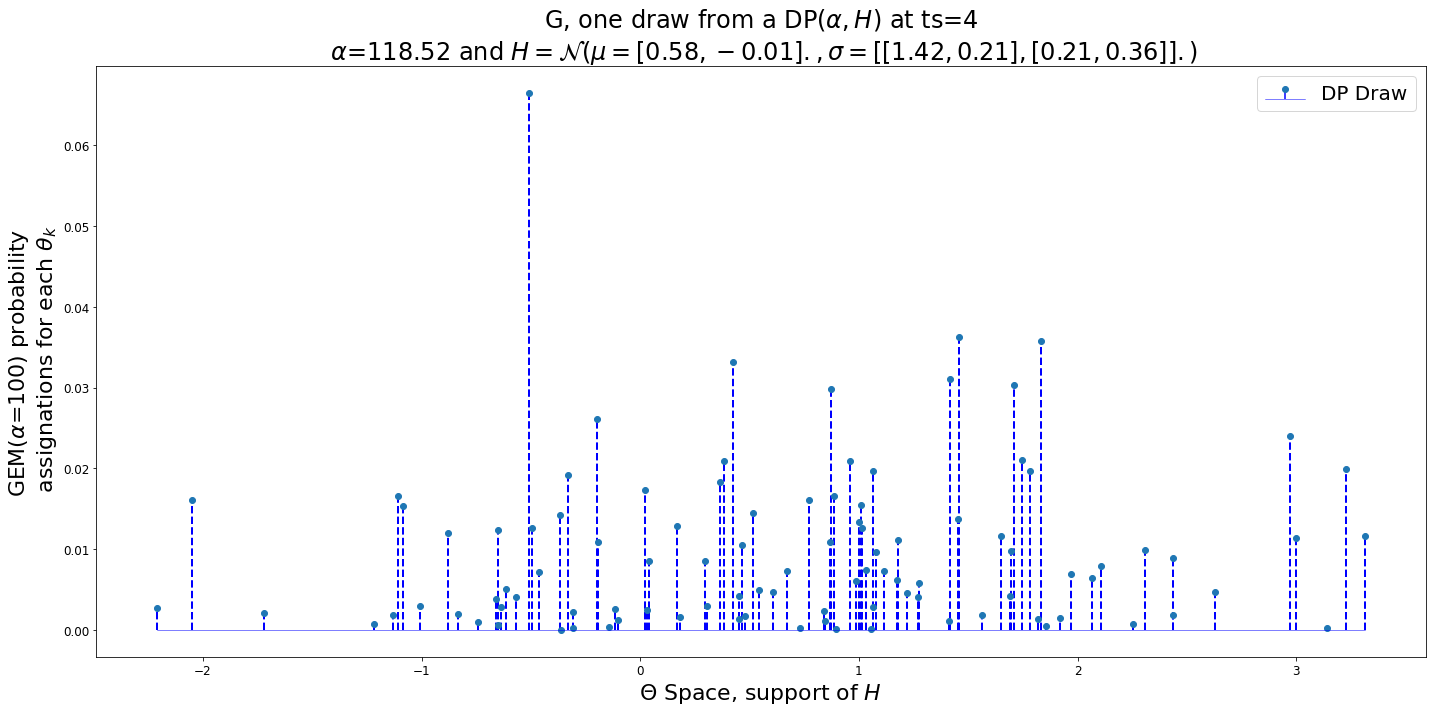

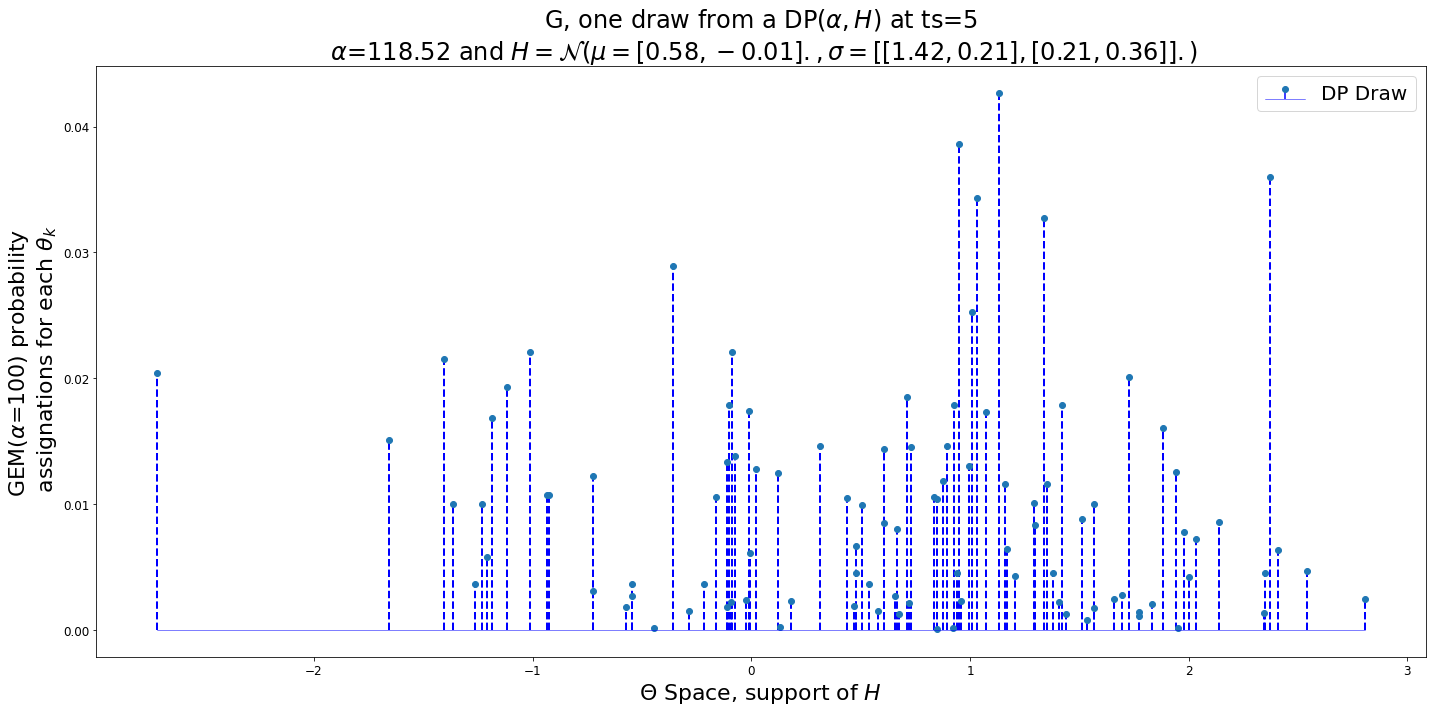

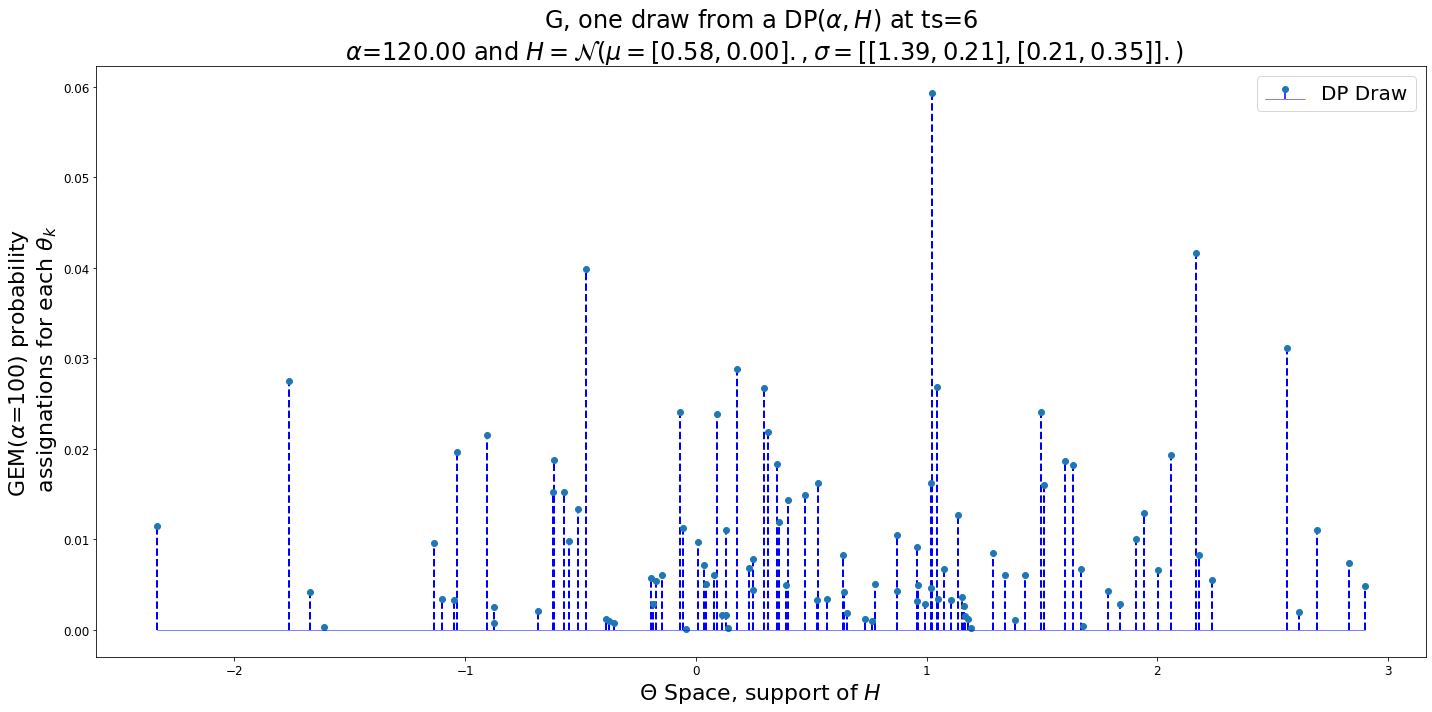

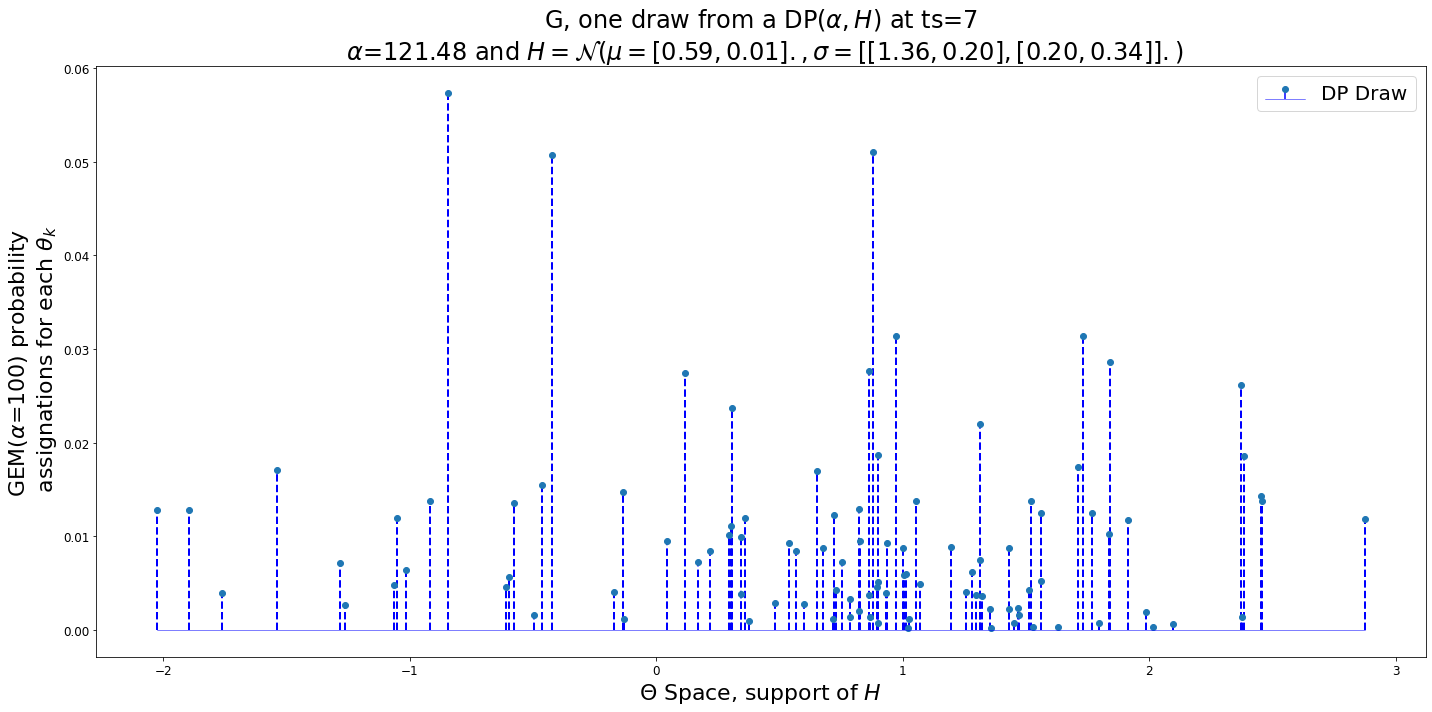

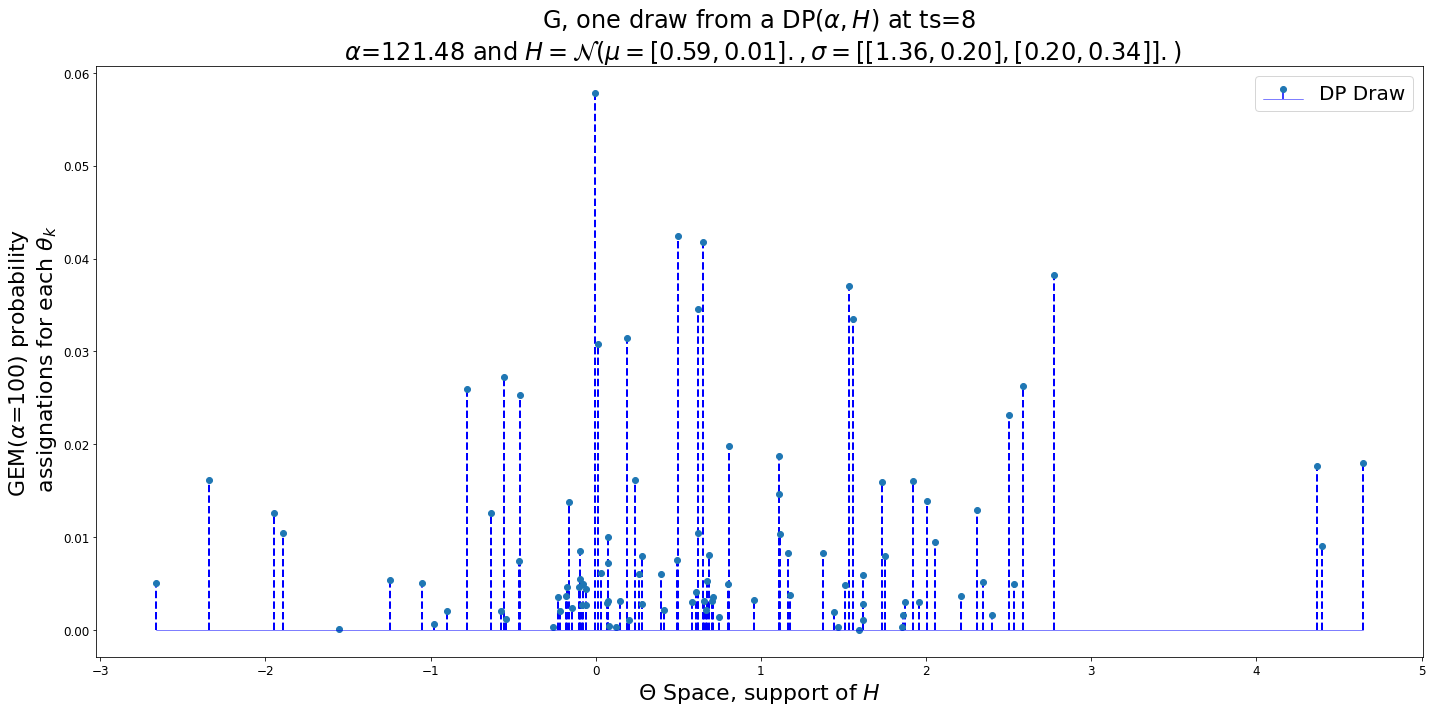

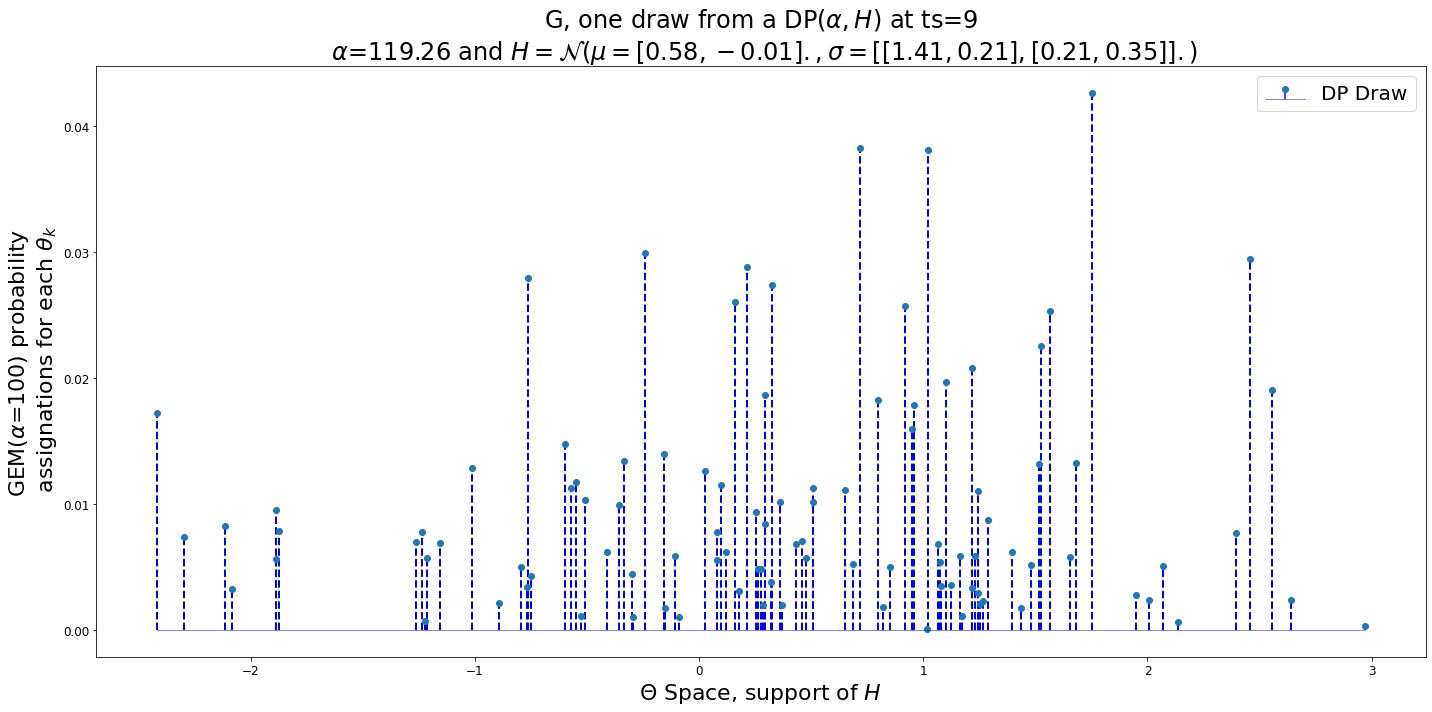

In [0]:
time_steps = list(dp_dict.keys())
time_steps.sort()
for ts in time_steps:
    dp_samples = dp_dict[ts]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)
    mu_1 = temporal_base_dist_params[ts][0][0]
    mu_2 = temporal_base_dist_params[ts][0][1]
    cov_11 = temporal_base_dist_params[ts][1][0][0]
    cov_12 = temporal_base_dist_params[ts][1][0][1]
    cov_21 = temporal_base_dist_params[ts][1][1][0]
    cov_22 = temporal_base_dist_params[ts][1][1][1]
    ax.set_title(r'G, one draw from a DP($\alpha, H$) at ts=' + str(ts) +'\n'+r' $\alpha$=%.2f and $H=\mathcal{N}(\mu=[%.2f, %.2f].,\sigma=[[%.2f, %.2f], [%.2f, %.2f]].)$' % (temporal_alphas[ts], mu_1, mu_2, cov_11, cov_12, cov_21, cov_22), size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    # plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

### TDP Clusters

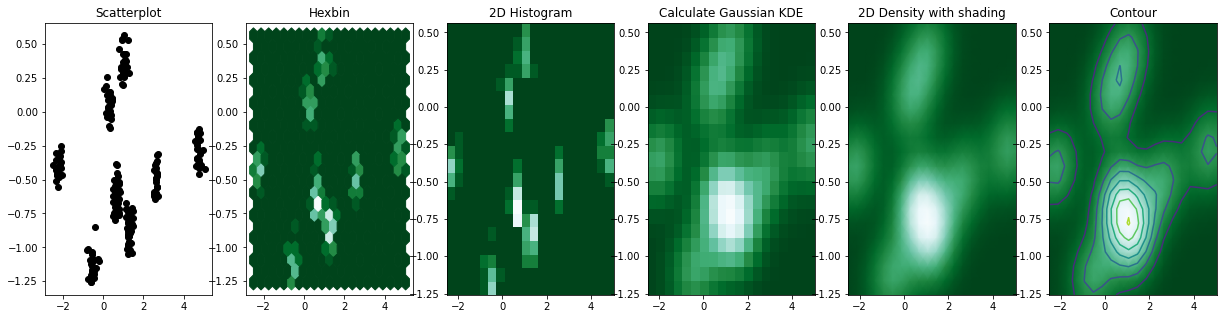

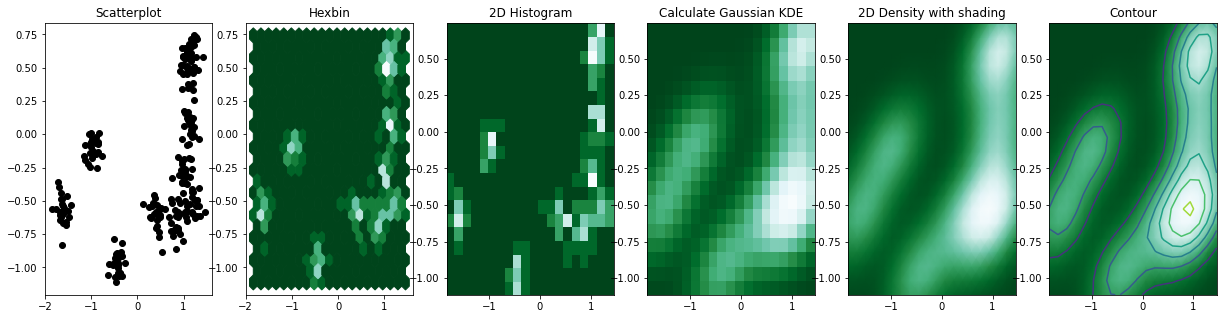

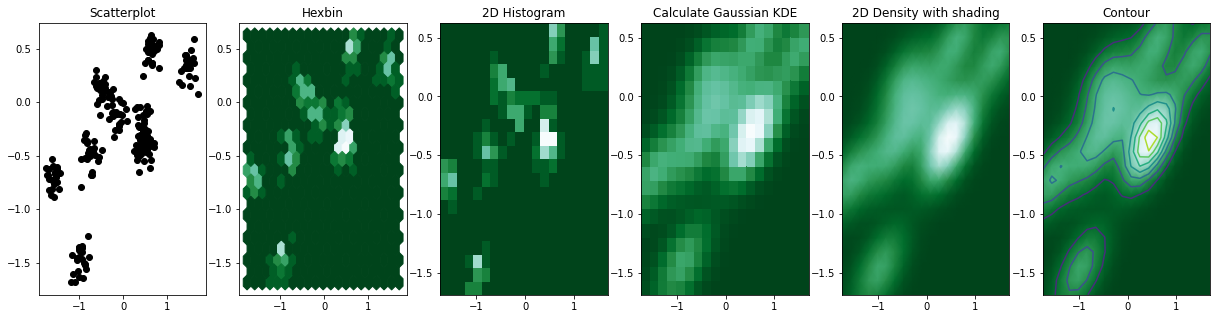

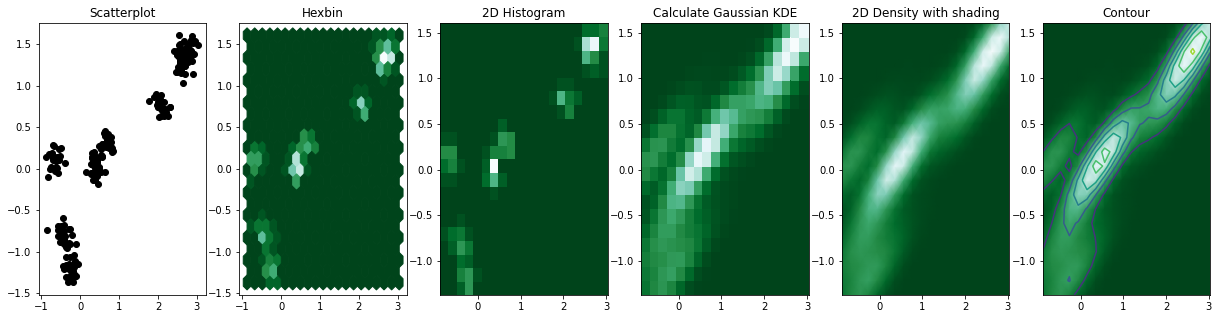

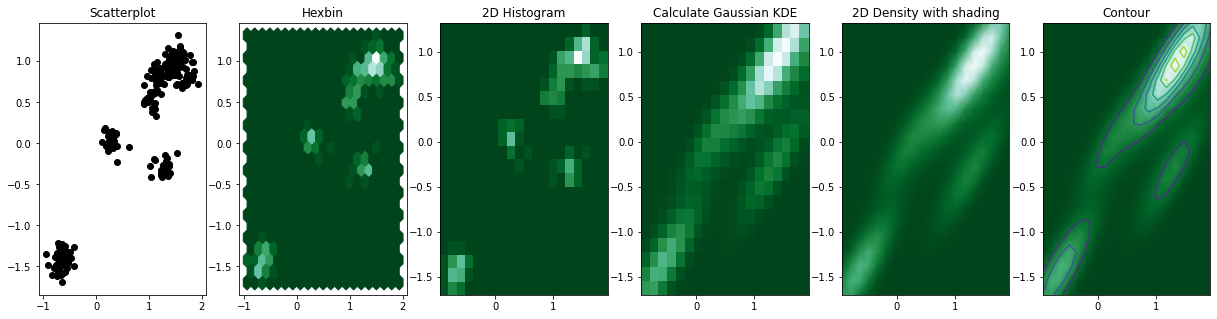

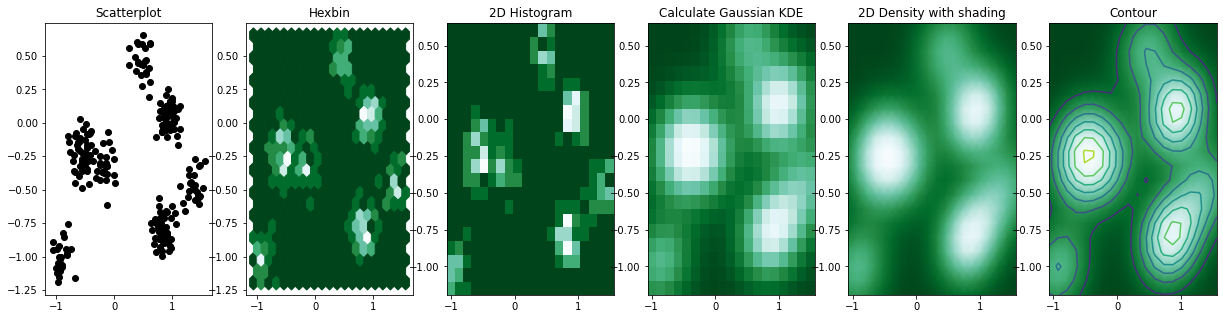

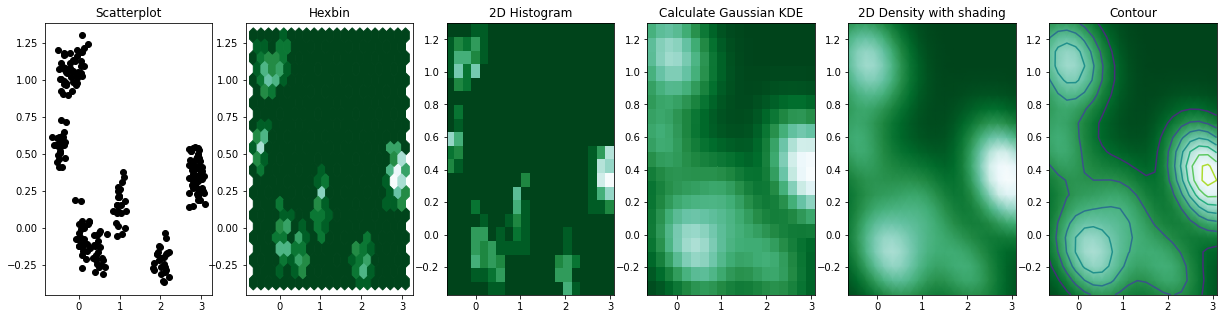

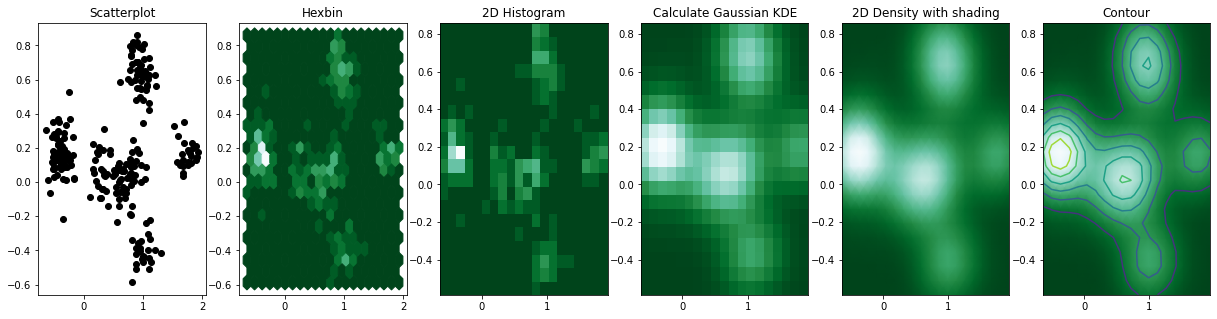

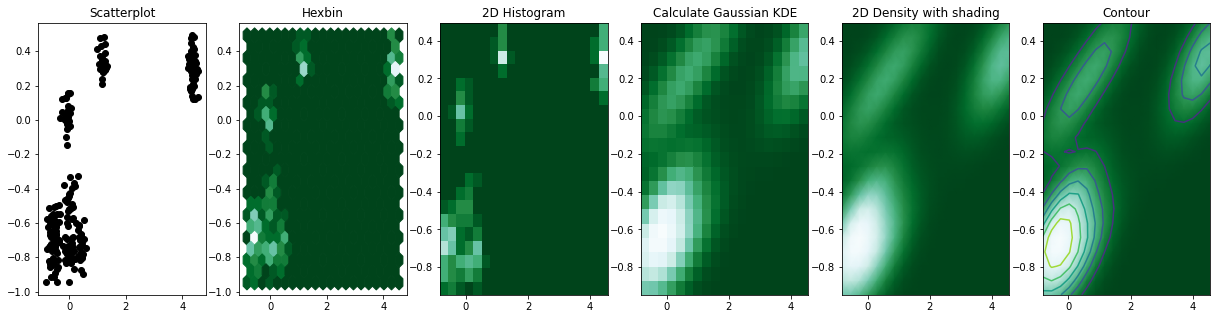

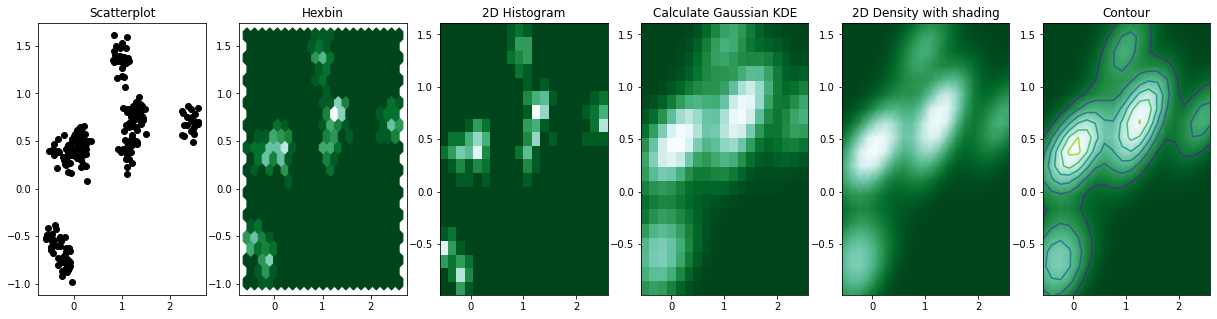

In [0]:
# Site for graphs: https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/
for ts in time_steps:
  data = gen_data[ts]
  x, y = data.T

  # Create a figure with 6 plot areas
  fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))
  
  # Everything sarts with a Scatterplot
  axes[0].set_title('Scatterplot')
  axes[0].plot(x, y, 'ko')
  # As you can see there is a lot of overplottin here!
  
  # Thus we can cut the plotting window in several hexbins
  nbins = 20
  axes[1].set_title('Hexbin')
  axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
  
  # 2D Histogram
  axes[2].set_title('2D Histogram')
  axes[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)
  
  # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
  k = kde.gaussian_kde(data.T)
  xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
  zi = k(np.vstack([xi.flatten(), yi.flatten()]))
  
  # plot a density
  axes[3].set_title('Calculate Gaussian KDE')
  axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
  
  # add shading
  axes[4].set_title('2D Density with shading')
  axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
  
  # contour
  axes[5].set_title('Contour')
  axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
  axes[5].contour(xi, yi, zi.reshape(xi.shape) )


### Generate Data

In [0]:
# # ALPHAS
# df_thdp_alphas = pd.DataFrame(temporal_alphas, columns = ['alpha']) 
# df_thdp_alphas.to_csv('thdp_alphas.csv') 
# files.download('thdp_alphas.csv')

# # print(np.array(thdp_data).shape)
# # print(temporal_alphas)
# # print(temporal_base_dist_params)

# # PARAMS
# temporal_base_dist_params_for_csv = []
# # Create np array with temporal base dist params
# for params in temporal_base_dist_params:
#   entry = []
#   entry.append(params[0][0])
#   entry.append(params[0][1])

#   entry.append(params[1][0][0])
#   entry.append(params[1][0][1])
#   entry.append(params[1][1][0])
#   entry.append(params[1][1][1])
#   temporal_base_dist_params_for_csv.append(entry)

# print(temporal_base_dist_params_for_csv)
# df_thdp_base_params = pd.DataFrame(temporal_base_dist_params_for_csv, columns = ['mu1', 'mu2', 'cov11', 'cov12', 'cov21', 'cov22']) 
# df_thdp_base_params.to_csv('df_thdp_base_params.csv') 
# files.download('df_thdp_base_params.csv')


# # G0s
# temporal_G0s = np.array(temporal_G0s)
# print(temporal_G0s.shape)
# temporal_G0s = temporal_G0s.reshape(steps*temporal_G0s.shape[1], temporal_G0s.shape[2])

# df_thdp_G0 = pd.DataFrame(temporal_G0s, columns = ['x1', 'x2']) 
# df_thdp_G0.to_csv('thdp_G_0.csv') 
# files.download('thdp_G_0.csv')

# DATA POINTS
thdp_data = np.array(gen_data).reshape(steps*2500, 2)
df_thdp_data = pd.DataFrame(thdp_data, columns = ['x1', 'x2']) 
df_thdp_data.to_csv('thdp_data.csv') 
files.download('thdp_data.csv')


## Writing a function for generating word2vec embedding

In [0]:
## word2vec generator
# !pip install pymc3
import theano
from theano import tensor as tt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from theano import shared
from collections import OrderedDict
from time import time
import pymc3 as pm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import bs4 as bs
import urllib.request
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pystan
from scipy.stats import multivariate_normal
import operator
# import arviz

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# The number of words in the vocabulary
n_words = 100

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")


INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading dataset...
done in 23.322s.
Extracting tf features for LDA...


In [0]:
len(data_samples)

# let us split the data samples into 3 documents
# and store them in a corpus dictionary
doc1 = data_samples[:3771]
doc2 = data_samples[3771:7542]
doc3 = data_samples[7542:]

# corpus_list needs to be initialized with list of text data
corpus_list = [doc1, doc2, doc3]
# input for the corpus preparation function

corpus_dict = {'doc'+str(i): item for i, item in enumerate(corpus_list)}

# t0 = time()
# tf_dict = {'doc'+str(i): tf_vectorizer.fit_transform(item)  for i, item in enumerate(corpus_list)}
# feature_names = tf_vectorizer.get_feature_names()
# print("done in %0.3fs." % (time() - t0))

In [0]:
len(corpus_dict['doc0'])

3771

In [0]:
corpus_dict.keys()

dict_keys(['doc0', 'doc1', 'doc2'])

In [0]:
for i, doc in enumerate(corpus_dict.keys()):
  print(i)
  print(doc)

0
doc0
1
doc1
2
doc2


In [0]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
# clean up the text data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
corpus_list[1][0:2]

['\nI no longer have the textbook, but abstinence was defined as something\nlike "no contact between the penis and the vagina, vulva, or area \nimmediately surrounding the vulva, and no transfer of semen to the\nvagina, vulva, or area surrounding the vulva".  \n\nThat is, abstinence wasn\'t discussed as "sex outside of marriage is\nmorally wrong" but as keep  the sperm away from the ovum and conception \nis impossible. The moral question I recall the teacher asking was,\n"is it okay to create a child if you aren\'t able to be a good parent\nyet?"\n\n-jen\n\n-- ',
 "\nGeez.  Everyone comes up with Clark, Williams, Thompson.  These guys\nwere all up in 1987.  That's ancient history.  So in the last 6 years,\nnoone, right?  Beck doesn't count.  I said 2 solid years.\n\n\nLet's see what he does w/o the help of a pitchout every other pitch.\nAs I remember, even Bob Brenly had a good throwout percentage under\nRoger Craig, who loved to sacrifice the count for runners being thrown\nout.  Of c

In [0]:
doc_j = tf_vectorizer_j.fit_transform(corpus_list[2])  
len(tf_vectorizer_j.get_feature_names())

100

In [0]:
word_data_dict = {}

for j, doc in enumerate(corpus_dict.keys()):
      # Cleaing the text
      processed_article = ''
      for paragraph in corpus_dict[doc]:
          processed_article += paragraph
          processed_article += ' '


      # learn a tf vectorizer and 
      tf_vectorizer_j = CountVectorizer(max_df=0.95, min_df=2, 
                                max_features=n_words, 
                                # If not None, build a vocabulary that 
                                # only consider the top max_features 
                                # ordered by term frequency across the corpus.
                                stop_words='english')
      t0 = time()
      doc_j = tf_vectorizer_j.fit_transform(corpus_list[j])  
      feature_names_j = tf_vectorizer_j.get_feature_names()
      print("done in %0.3fs." % (time() - t0))


      processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
      processed_article = re.sub(r'\s+', ' ', processed_article)

      # Preparing the dataset
      all_sentences = nltk.sent_tokenize(processed_article)
      all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

      # Removing Stop Words
      for i in range(len(all_words)):
          all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

      word2vec = Word2Vec(all_words, size=5, min_count=1)

      # {'doc'+str(i): item for i, item in enumerate(corpus_list)}

      word_data = {}

      ###################################################################
      ##### feature_names need to be different for different docs ??? ########
      ###################################################################

      for word in feature_names_j:
        try:
          word_data[word] = list(word2vec.wv[word])
        except:
          print(word)
      word_data = pd.DataFrame(word_data).T

      print(word_data)
      print('w2c_doc'+str(j))
      print('item index: ', j)
      word_data_dict['w2c_doc'+str(j)] = word_data

# print(word_data_dict)


done in 0.444s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 50242 word types from a corpus of 461596 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 50242 unique words (100% of original 50242, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 461596 word corpus (100% of original 461596, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 50242 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 26 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 430400 word corpus (93.2% of prior 461596)
INFO:gensim.models.base_any2vec:estimated required memory for 50242 words and 5 dimensions: 27130680 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

00
10
15
16
20
50
did
didn
does
doesn
don
g9v
just
ll
mr
ve
                  0         1         2         3         4
available  0.091704 -0.067649 -0.008342  0.024474  0.011795
ax         0.069131  0.038916  0.066816 -0.043318 -0.040108
believe   -0.050799  0.073411 -0.026302 -0.006761  0.000083
best       0.044056 -0.054566 -0.002072  0.074131 -0.086226
better     0.014599 -0.086712  0.053160 -0.074878  0.082320
...             ...       ...       ...       ...       ...
windows    0.073421 -0.053722  0.064784  0.036838  0.056195
work      -0.037385 -0.003484 -0.000093 -0.040205  0.026944
world     -0.055740 -0.102837 -0.078157  0.088316  0.083384
year      -0.043085 -0.079719  0.059199 -0.077247 -0.001092
years      0.011489 -0.098670 -0.065475  0.049795  0.012137

[84 rows x 5 columns]
w2c_doc0
item index:  0
done in 0.462s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 48144 word types from a corpus of 501377 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 48144 unique words (100% of original 48144, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 501377 word corpus (100% of original 501377, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 48144 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 17 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 454988 word corpus (90.7% of prior 501377)
INFO:gensim.models.base_any2vec:estimated required memory for 48144 words and 5 dimensions: 25997760 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

00
000
10
12
15
16
20
did
didn
does
doesn
don
just
ll
mr
ve
                  0         1         2         3         4
available  0.095299 -0.049351 -0.014100  0.024608  0.020471
ax         0.069131  0.038916  0.066816 -0.043318 -0.040108
believe   -0.049613  0.070953 -0.030219 -0.012857  0.003346
best       0.047106 -0.050907 -0.003840  0.070457 -0.085615
better     0.018448 -0.090605  0.054293 -0.082104  0.085371
...             ...       ...       ...       ...       ...
windows    0.074226 -0.051644  0.064157  0.036695  0.057150
work      -0.031702  0.002580 -0.002504 -0.042779  0.030621
world     -0.051896 -0.096408 -0.080042  0.087083  0.086452
year      -0.041126 -0.078694  0.060007 -0.077795  0.000178
years      0.015872 -0.100435 -0.067604  0.045213  0.013515

[84 rows x 5 columns]
w2c_doc1
item index:  1
done in 0.477s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 50709 word types from a corpus of 510374 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 50709 unique words (100% of original 50709, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 510374 word corpus (100% of original 510374, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 50709 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 27 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 462309 word corpus (90.6% of prior 510374)
INFO:gensim.models.base_any2vec:estimated required memory for 50709 words and 5 dimensions: 27382860 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

0t
10
11
12
14
145
15
16
17
1d9
20
25
30
34u
a86
ax
b8f
did
didn
does
doesn
don
g9v
just
ll
ve
                  0         1         2         3         4
available  0.092449 -0.055069 -0.013046 -0.005162  0.019398
based     -0.082430 -0.064712 -0.082045  0.085539 -0.092282
believe   -0.049448  0.074146 -0.029816 -0.013283  0.000763
best       0.043799 -0.049839 -0.002867  0.064163 -0.085548
better     0.016872 -0.088547  0.052510 -0.088017  0.083982
...             ...       ...       ...       ...       ...
windows    0.074285 -0.052139  0.064904  0.033443  0.057132
work      -0.034994  0.005521 -0.003755 -0.051690  0.028957
world     -0.053689 -0.095718 -0.080685  0.079461  0.086300
year      -0.041521 -0.079635  0.057870 -0.090128  0.000193
years      0.012512 -0.095662 -0.067500  0.042765  0.014150

[74 rows x 5 columns]
w2c_doc2
item index:  2


In [0]:
word_data_dict.keys()

dict_keys(['w2c_doc0', 'w2c_doc1', 'w2c_doc2'])

In [0]:
word_data_dict['w2c_doc0']

,0,1,2,3,4
available,0.091704,-0.067649,-0.008342,0.024474,0.011795
ax,0.069131,0.038916,0.066816,-0.043318,-0.040108
believe,-0.050799,0.073411,-0.026302,-0.006761,0.000083
best,0.044056,-0.054566,-0.002072,0.074131,-0.086226
better,0.014599,-0.086712,0.053160,-0.074878,0.082320
...,...,...,...,...,...
windows,0.073421,-0.053722,0.064784,0.036838,0.056195
work,-0.037385,-0.003484,-0.000093,-0.040205,0.026944
world,-0.055740,-0.102837,-0.078157,0.088316,0.083384
year,-0.043085,-0.079719,0.059199,-0.077247,-0.001092


In [0]:
word_data_dict['w2c_doc1']

,0,1,2,3,4
available,0.095299,-0.049351,-0.014100,0.024608,0.020471
ax,0.069131,0.038916,0.066816,-0.043318,-0.040108
believe,-0.049613,0.070953,-0.030219,-0.012857,0.003346
best,0.047106,-0.050907,-0.003840,0.070457,-0.085615
better,0.018448,-0.090605,0.054293,-0.082104,0.085371
...,...,...,...,...,...
windows,0.074226,-0.051644,0.064157,0.036695,0.057150
work,-0.031702,0.002580,-0.002504,-0.042779,0.030621
world,-0.051896,-0.096408,-0.080042,0.087083,0.086452
year,-0.041126,-0.078694,0.060007,-0.077795,0.000178


In [0]:
word_data_dict['w2c_doc2']

,0,1,2,3,4
available,0.092449,-0.055069,-0.013046,-0.005162,0.019398
based,-0.082430,-0.064712,-0.082045,0.085539,-0.092282
believe,-0.049448,0.074146,-0.029816,-0.013283,0.000763
best,0.043799,-0.049839,-0.002867,0.064163,-0.085548
better,0.016872,-0.088547,0.052510,-0.088017,0.083982
...,...,...,...,...,...
windows,0.074285,-0.052139,0.064904,0.033443,0.057132
work,-0.034994,0.005521,-0.003755,-0.051690,0.028957
world,-0.053689,-0.095718,-0.080685,0.079461,0.086300
year,-0.041521,-0.079635,0.057870,-0.090128,0.000193
